# Support Vector Machines (SVM) using Scikit-Learn

**Author**:Sarvin Raaj Gunasekar


This Jupyter Notebook provides examples on how to load the data sets and perform a simple machine learning classification task.

We will be using different modelling techniques such as:

* Deep Neural Network
* Support Vector Machine

In Support Vector Machine we will be using these classification methods:
* Linear SVC
* NU SVC

# Load the data set

We begin by importing a few essential libraries and then loading one of the data sets.

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The data set is available in two formats: ROOT and HDF5. In this example we are using ROOT.
The uproot package can be used to read a .root file to Python without having to necessarily install the whole ROOT software.

In [2]:
# Load a ROOT file
filePath='../files/JetNtuple_RunIISummer16_13TeV_MC_1_skimmed.root'
tree = uproot.open(filePath)['jetTree']



In [3]:
# Create and fill a dataframe
df = pd.DataFrame()
remaining_vars = []


Creating Flags for different modelling techniques such as Deep Neural Network, Simple Vector Machine, Linear SVC and NU SVC make it easier to compare the result.

In [4]:
PLOT = True
DO_DNN = True
DO_SVM = True 
VERBOSE = False
DO_Lin = True
DO_Nu  = True 

# Classification Quark/gluon jet

This machine learning example is the classification of jets originating either from gluons or the three of the lightest quarks (up, down and strange). This is an important task, since on the observable macroscopic level the two types of jets look very similar, but from a physical point of view the difference between them is significant.



In [5]:
for key in tree.keys():
   
   #TO-DO: Figure out how to accomodate awkward arrays
   if str(type(tree[key].array()[0])) != "<class 'awkward.highlevel.Array'>":
      df[key] = np.array(tree[key].array())
   else:
      remaining_vars.append(key)
   pass

if VERBOSE:   
   print("Remaining variables not accounted for:")
   print(remaining_vars)

# First remove all the other types of jets from the data except the gluon and the light quark (UDS) jets
df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()

if VERBOSE:   
   print(df)

From left to right these variables are the **jet multiplicity (QG_mult)**, the **jet momentum distribution variable (QG_ptD)** and the **jet minor axis (QG_axis2)**. The distributions display statistical differences between the two types of jets.

**Jet multiplicity** is the number of particles contained in the jet (subject to certain constraints on the properties of the particles, see CMS-PAS-JME-13-002 again). Gluons are expected to radiate more intensely, so on average gluon jets contain more particles.

**The jet momentum distribution variable** is defined as $ p_{T} D = \frac{\sqrt{\sum_i p_{T,i}^2}}{\sum_i p_{T,i}} $ where $p_{T,i} $is the transverse momentum of a particle and the sum $ i $ is over the jet's constituents. It describes how the total transverse momentum of a jet is distributed to its constituents. Quark jets are expected to have fewer constituents carrying the majority of the jet's momentum, which means that the value of the transverse momentum of a particle is on average larger for quark jets.

**The jet minor axis** (often also denoted by $ \sigma_{2} $) describes the width of the jet when it is approximated as an ellipse. Gluon jets are on average wider than quark jets.


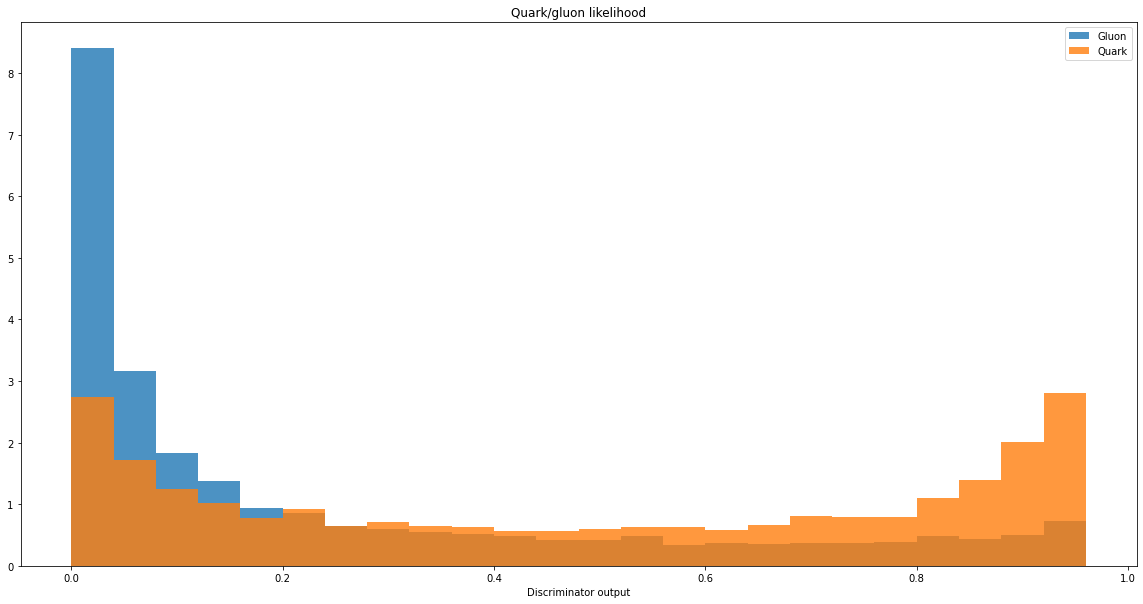

In [6]:
if PLOT:
   
   hist_columns = ['QG_mult','QG_ptD','QG_axis2']
   binnings = [np.arange(0,70,2), np.arange(0.0,1.0,0.04), np.arange(0.0,0.2,0.01)]

   ind = 0
   fig, axes = plt.subplots(1, 3, figsize=(20,10))

   for column in hist_columns:
      axes[ind].hist( df[df.isPhysG==1][column], bins=binnings[ind], alpha=0.8, label='Gluon', density=1 )
      axes[ind].hist( df[df.isPhysUDS==1][column], bins=binnings[ind], alpha=0.8, label='Quark', density=1 )
      axes[ind].set_xlabel(column)
      axes[ind].legend()
      ind = ind+1

   plt.savefig("./ML_vars.png")
   plt.clf()

   binning = np.arange(0.0, 1.0, 0.04)
   plt.hist( df[df.isPhysG==1]['jetQGl'], bins=binning, alpha=0.8, label='Gluon', density=1 )
   plt.hist( df[df.isPhysUDS==1]['jetQGl'], bins=binning, alpha=0.8, label='Quark', density=1 )
   plt.legend()
   plt.xlabel('Discriminator output')
   plt.title('Quark/gluon likelihood')

   plt.savefig("./ML_QGL.png")


# Processing data using specific modelling techniqus

We are about to process the data using the different modelling techniques.Before that we have to seperate them according to the modelling techniques(Deep Neural Network,Simple Vector Machine,Linear SVC,NU SVC). Our target output is the isPhysUDS column, the value of which is one for light quark jets and zero for gluon jets. Hence the output will be similar to the likelihood discriminator, allowing us to directly compare their performance.

Then we choose the input features for the modelling techniques. In addition to the three variables, let's add the transverse momentum of the jet (**jetPT**) and the pseudorapidity of the jet (**jetEta**). 

We will also perform some basic preprocessing in the form of normalizing the input features by columnwise subtraction of the mean and division by the standard deviation.

In [7]:
#
# Preprocessing
#

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

test_y = test.isPhysUDS

input_features = ['jetPt', 'jetEta', 'QG_mult', 'QG_ptD', 'QG_axis2']

if DO_SVM:

   train_x_svm = train[input_features]
   train_y_svm = train.isPhysUDS

   test_x_svm = test[input_features]
   test_y_svm = test.isPhysUDS

   train_x_mean_svm = train_x_svm.mean()
   train_x_std_svm = train_x_svm.std()

   train_x_svm = (train_x_svm - train_x_mean_svm) / train_x_std_svm
   test_x_svm = (test_x_svm - train_x_mean_svm) / train_x_std_svm

if DO_DNN:

   train_y_dnn = train.isPhysUDS
   test_y_dnn = test.isPhysUDS


   train_x_dnn = train[input_features]
   test_x_dnn = test[input_features]

   # Normalize the features
   train_x_mean_dnn = train_x_dnn.mean()
   train_x_std_dnn = train_x_dnn.std()

   train_x_dnn = (train_x_dnn - train_x_mean_dnn) / train_x_std_dnn
   test_x_dnn = (test_x_dnn - train_x_mean_dnn) / train_x_std_dnn


if DO_Lin:

   train_x_lin = train[input_features]
   train_y_lin = train.isPhysUDS

   test_x_lin = test[input_features]
   test_y_lin = test.isPhysUDS

   train_x_mean_lin = train_x_lin.mean()
   train_x_std_lin = train_x_lin.std()

   train_x_lin = (train_x_lin - train_x_mean_lin) / train_x_std_lin
   test_x_lin = (test_x_lin - train_x_mean_lin) / train_x_std_lin

if DO_Nu:

   train_x_nu = train[input_features]
   train_y_nu = train.isPhysUDS

   test_x_nu = test[input_features]
   test_y_nu = test.isPhysUDS

   train_x_mean_nu = train_x_nu.mean()
   train_x_std_nu = train_x_nu.std()

   train_x_nu = (train_x_nu - train_x_mean_nu) / train_x_std_nu
   test_x_nu = (test_x_nu - train_x_mean_nu) / train_x_std_nu




We are ready to build and train our model using **deep neural network**.

In [8]:
if DO_DNN:

   import tensorflow as tf
   import keras.backend as K

   sess = tf.compat.v1.Session()
   tf.compat.v1.keras.backend.set_session(sess)

   from keras.models import Model, Sequential
   from keras.layers import Input, Dense, Dropout
   from sklearn.utils import class_weight

   # Define the DNN architecture
   model = Sequential()
   model.add(Dense(64, kernel_initializer='normal', activation='relu', input_dim=train_x_dnn.shape[1]))
   model.add(Dropout(0.2))
   model.add(Dense(64, kernel_initializer='normal', activation='relu'))
   model.add(Dropout(0.2))
   model.add(Dense(32, kernel_initializer='normal', activation='relu'))
   model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
   model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])
   
 #Weight the training samples so that there is equal weight on gluon and quark jets
 #even if there are different amount of them in the training set
   
class_weights = class_weight.compute_class_weight(
                                                      class_weight = 'balanced', 
                                                      classes = np.unique(train_y_dnn), 
                                                      y = train_y_dnn
                                                    )
                                                      
class_weights = dict(zip(np.unique(train_y_dnn), class_weights))

# Train the model
model.fit(train_x_dnn,           
             train_y_dnn,
             epochs=20,
             batch_size=128,
             class_weight=class_weights,
             validation_split=0.2,
             shuffle=True,
             verbose=1);
    
    

2022-01-04 02:34:22.989979: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-04 02:34:22.992130: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



Epoch 1/20


2022-01-04 02:34:23.463960: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-01-04 02:34:23.593582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


70/70 [==============================] - 3s 31ms/step - loss: 0.6058 - accuracy: 0.6810 - val_loss: 0.5358 - val_accuracy: 0.7309
Epoch 2/20
70/70 [==============================] - 2s 23ms/step - loss: 0.5339 - accuracy: 0.7412 - val_loss: 0.5071 - val_accuracy: 0.7556
Epoch 3/20
70/70 [==============================] - 2s 26ms/step - loss: 0.5288 - accuracy: 0.7436 - val_loss: 0.5181 - val_accuracy: 0.7471
Epoch 4/20
70/70 [==============================] - 2s 26ms/step - loss: 0.5251 - accuracy: 0.7471 - val_loss: 0.5048 - val_accuracy: 0.7552
Epoch 5/20
70/70 [==============================] - 2s 27ms/step - loss: 0.5252 - accuracy: 0.7505 - val_loss: 0.5339 - val_accuracy: 0.7435
Epoch 6/20
70/70 [==============================] - 2s 22ms/step - loss: 0.5237 - accuracy: 0.7488 - val_loss: 0.5060 - val_accuracy: 0.7570
Epoch 7/20
70/70 [==============================] - 1s 19ms/step - loss: 0.5225 - accuracy: 0.7494 - val_loss: 0.5210 - val_accuracy: 0.7480
Epoch 8/20
70/70 [======

By creating predictions for the test set and plotting the classifier output we can  see how the trained model performs.

<Figure size 432x288 with 0 Axes>

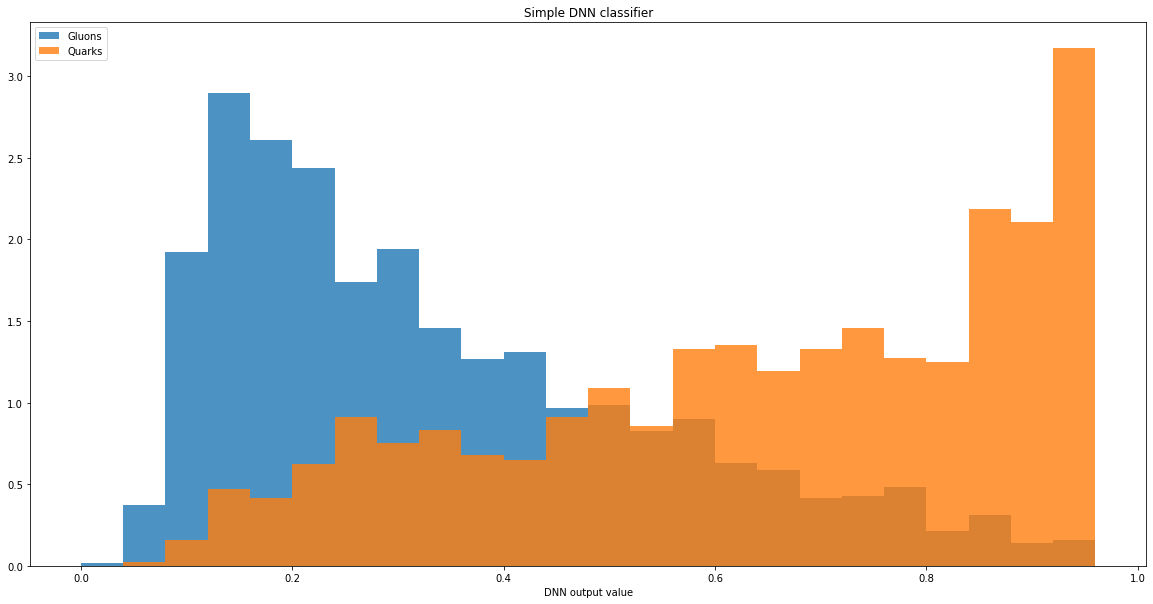

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


pred_y_dnn = model.predict(test_x_dnn)


if PLOT and DO_DNN:

   plt.clf()
   binning = np.arange(0.0, 1.0, 0.04)
   plt.figure( figsize=(20,10))
   plt.hist( pred_y_dnn[test_y_dnn==0], bins=binning, alpha=0.8, label="Gluons", density=1 )
   plt.hist( pred_y_dnn[test_y_dnn==1], bins=binning, alpha=0.8, label="Quarks", density=1 )
   plt.legend()
   plt.xlabel('DNN output value')
   plt.title('Simple DNN classifier')
   plt.savefig("ML_DNNClassifier.png")

# Plot for ROC Curve
if DO_DNN:
   fpr_dnn, tpr_dnn, thresholds_dnn  = roc_curve(test_y_dnn, pred_y_dnn)
   roc_auc_dnn = auc(fpr_dnn, tpr_dnn)



In order to fairly compare our newly trained model and the traditional likelihood discriminator, we should look at the corresponding receiver operating characteristic (ROC) curves. Therefore in the following classifier we will not plot the classifier output graph. Instead we will directly plot the ROC curve all in the same graph.

# Support Vector Machine

In machine learning, support-vector machines (SVMs, also support-vector networks) are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis.

This example is made with reference from [Scikit-Learn](https://scikit-learn.org/stable/modules/svm.html#) documentation on Support Vector Machine.

In SVM the method used is decision_function to compute the **decision function** for test_x. 

In [10]:


if DO_SVM:

   from sklearn.svm import SVC

   clf = SVC(kernel="poly", random_state=42).fit(train_x_svm, train_y_svm)

   # Prediction on the test set 
   pred_y_svm = clf.decision_function(test_x_svm)
    
   # Plot for ROC Curve 
   fpr_svm, tpr_svm, thresholds_svm  = roc_curve(test_y_svm, pred_y_svm)
   roc_auc_svm = auc(fpr_svm, tpr_svm)
 

   

# Linear SVC using SVM

The primal problem can be equivalently formulated as

 $\min_ {w, b} \frac{1}{2} w^T w + C \sum_{i=1}\max(0, 1 - y_i (w^T \phi(x_i) + b)),$
 
 
where we make use of the hinge loss. This is the form that is directly optimized by LinearSVC, but unlike the dual form, this one does not involve inner products between samples, so the famous kernel trick cannot be applied. This is why only the linear kernel is supported by LinearSVC ($\phi$ is the identity function).


This example is made with reference from [Scikit-Learn](https://scikit-learn.org/stable/modules/svm.html#linearsvc) documentation on Linear SVC.

The method used to predict the test set in Linear SVC is the same as SVM which is **decision_function**.
Further explanation on the method is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linear%20svc#examples-using-sklearn-svm-linearsvc)

In [13]:

if DO_Lin:

   from sklearn.svm import LinearSVC

   clf = LinearSVC(loss="hinge", random_state=42).fit(train_x_lin, train_y_lin)

   # Prediction on the test set 
   pred_y_lin = clf.decision_function(test_x_lin) 

   # Plot for ROC Curve  
   fpr_lin, tpr_lin, thresholds_lin  = roc_curve(test_y_lin, pred_y_lin)
   roc_auc_lin = auc(fpr_lin, tpr_lin)  

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# Nu SVC using SVM
The $\nu$-SVC formulation 15 is a reparameterization of the $C$-SVC and therefore mathematically equivalent.

We introduce a new parameter $\nu$ (instead of $C$ ) which controls the number of support vectors and margin errors:$\nu \in (0, 1]$  is an upper bound on the fraction of margin errors and a lower bound of the fraction of support vectors. A margin error corresponds to a sample that lies on the wrong side of its margin boundary: it is either misclassified, or it is correctly classified but does not lie beyond the margin.

This example is made with reference from [Scikit-Learn](https://scikit-learn.org/stable/modules/svm.html#nusvc) documentation on Linear SVC.

The method used to predict the test set in Nu SVC is the same as before which is **decision_function**.
Further explanation on the method available for Histogram Gradient Tree Boosting is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html?highlight=svm%20nusvc#sklearn.svm.NuSVC.decision_function)



In [14]:


if DO_Nu:
    
    from sklearn.svm import NuSVC
   
    # Prediction on the test set 
    pred_y_nu = clf.decision_function(test_x_nu) 
    
    # Plot for ROC Curve
    fpr_nu, tpr_nu, thresholds_nu  = roc_curve(test_y_nu, pred_y_nu)
    roc_auc_nu = auc(fpr_lin, tpr_nu) 

# Plotting ROC Curve

Here we can compare the AUC of the different modelling techniques and see which have the better performance of the classifier.Larger the area under the curve (AUC), better the performance of the classifier.

<Figure size 432x288 with 0 Axes>

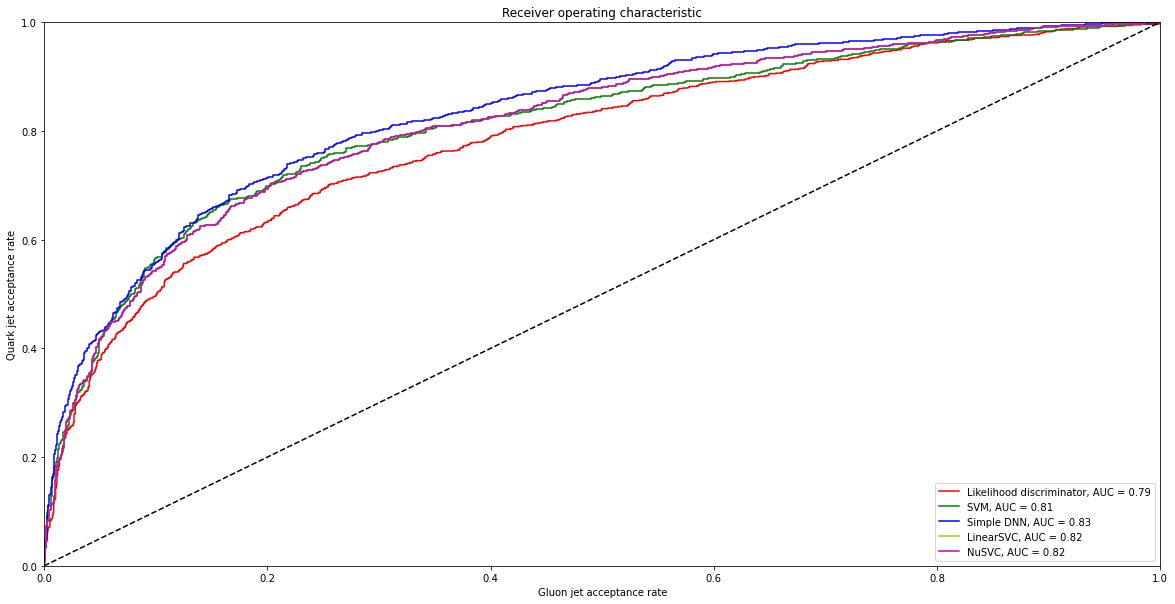

In [15]:

#Plot for ROC (likelihood Discriminator)
fpr_qgl, tpr_qgl, thresholds_qgl = roc_curve(test_y, test.jetQGl)
roc_auc_qgl = auc(fpr_qgl, tpr_qgl)

if PLOT:

   plt.clf()
   plt.figure( figsize=(20,10)) 
   plt.plot(fpr_qgl, tpr_qgl, 'r', label='Likelihood discriminator, AUC = %0.2f'% roc_auc_qgl)

   if DO_SVM: 
        plt.plot(fpr_svm, tpr_svm, 'g', label='SVM, AUC = %0.2f'% roc_auc_svm)
   if DO_DNN: 
        plt.plot(fpr_dnn, tpr_dnn, 'b', label='Simple DNN, AUC = %0.2f'% roc_auc_dnn)
   if DO_Lin: 
        plt.plot(fpr_lin, tpr_lin, 'y', label='LinearSVC, AUC = %0.2f'% roc_auc_lin)
   if DO_Nu:
        plt.plot(fpr_nu, tpr_nu, 'm', label='NuSVC, AUC = %0.2f'% roc_auc_nu)
   
   plt.plot([0,1], [0,1], 'k--')
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.0])
   plt.legend(loc = 'lower right')
   plt.title("Receiver operating characteristic")
   plt.ylabel('Quark jet acceptance rate')
   plt.xlabel('Gluon jet acceptance rate');
   plt.savefig("SVM New.png")